In [1]:
import os
import matplotlib.pyplot as plt
from matplotlib import rc
import numpy as np
from scipy.constants import c
from scipy.optimize import curve_fit
from uncertainties import ufloat
from uncertainties import unumpy as unp
import array_to_latex as a2l
import csv
import pandas as pd
import sympy as sym
import fprlib as fp
import glob

rc('font', **{'family': 'serif', 'serif': ['Computer Modern']}) #font na grafih je LaTexov
rc('text', usetex=True)

#x,y = np.loadtxt('osciloskop_meritve.csv', delimiter=',', skiprows=1, unpack=True)

"""
# Grafiranje:

fig, ax = plt.subplots()

ax.plot(x, y, c="darkblue", ls="-", lw=0.5, label=r"Napetost na vezju")
ax.plot([-0.07,0.07], [32,32],c="r", ls="-", lw=0.4, label=r"32 V napetost")
ax.grid(True, which="both")
plt.xlabel(r"Čas [s]")
plt.ylabel(r"Amplituda [V]")
plt.legend(loc='best')
#ax.set_ylim([-1, 1])
ax.set_xlim([-0.00005, 0.0007])
plt.title("Začetno odstopanje napetosti skozi vezje tuljave")
fig.show()
fig.savefig("start_impulse", dpi=600, bbox_inches='tight', transparent=False)
"""
print("...") # Narejeno da ne izpiše celotnega block comment-a zgoraj \lol

...


In [3]:
cal_data = np.loadtxt("meritve1.txt")

delta_T = cal_data[:, 1] - cal_data[:, 0]
U =  unp.uarray(cal_data[:,2], [0.005]*18)

dT = unp.uarray(delta_T, [2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 0.5, 0.5,0.5, 0.5,0.5,])
dT, U

(array([73.0+/-2.0, 71.8+/-2.0, 70.3+/-2.0, 65.7+/-2.0, 58.4+/-2.0,
        53.49999999999999+/-2.0, 46.9+/-1.0, 42.1+/-1.0, 38.8+/-1.0,
        36.1+/-1.0, 28.5+/-1.0, 28.299999999999997+/-1.0,
        19.699999999999996+/-1.0, 17.1+/-0.5, 13.399999999999999+/-0.5,
        9.599999999999998+/-0.5, 8.099999999999998+/-0.5,
        84.60000000000001+/-0.5], dtype=object),
 array([3.103+/-0.005, 3.03+/-0.005, 2.964+/-0.005, 2.755+/-0.005,
        2.4375+/-0.005, 2.226+/-0.005, 1.94+/-0.005, 1.732+/-0.005,
        1.59+/-0.005, 1.476+/-0.005, 1.153+/-0.005, 1.128+/-0.005,
        0.783+/-0.005, 0.681+/-0.005, 0.525+/-0.005, 0.373+/-0.005,
        0.312+/-0.005, 3.571+/-0.005], dtype=object))

In [23]:
data_tex = np.array([delta_T, unp.nominal_values(U)])
print(a2l.to_ltx(data_tex.T, frmt = "{:6.3f}", arraytype="array"))

\begin{array}{ c, c}
  73.000 &   3.103\\
  71.800 &   3.030\\
  70.300 &   2.964\\
  65.700 &   2.755\\
  58.400 &   2.438\\
  53.500 &   2.226\\
  46.900 &   1.940\\
  42.100 &   1.732\\
  38.800 &   1.590\\
  36.100 &   1.476\\
  28.500 &   1.153\\
  28.300 &   1.128\\
  19.700 &   0.783\\
  17.100 &   0.681\\
  13.400 &   0.525\\
   9.600 &   0.373\\
   8.100 &   0.312\\
  84.600 &   3.571
\end{array}
None


In [7]:
def lin(x, k, n):
    return k*x + n
par, cov = curve_fit(lin, unp.nominal_values(U), unp.nominal_values(dT), sigma=unp.std_devs(dT), absolute_sigma=True)

k, n  = par
dk, dn = np.sqrt(np.diag(cov))

k, dk, n, dn

(23.438375121841677,
 0.16620527029633295,
 1.0939055016450676,
 0.2804000531973269)

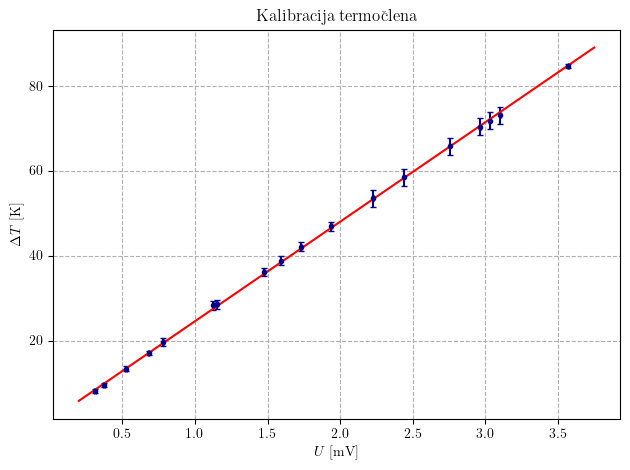

In [9]:
fig, ax = plt.subplots()

ax.errorbar(unp.nominal_values(U), unp.nominal_values(dT), xerr=unp.std_devs(U), yerr=unp.std_devs(dT), fmt=".",color="darkblue", capsize=2)
napetost = np.linspace(0.2, 3.75)

ax.plot(napetost, lin(napetost, k, n), color="r")

ax.set_title(r'Kalibracija termočlena')
ax.set_xlabel(r'$U$ [mV]')
ax.set_ylabel(r"$\Delta T$ [K]")
ax.grid(ls="--")
fig.tight_layout()
fig.savefig("kalibracija")

In [21]:
data = np.loadtxt("meritve2.txt")

P = data[:, 0]
U1 = data[:, 1]

data1 = np.array([P, U1])
print(a2l.to_ltx(data1.T, frmt="{:6.5f}", arraytype="array"))

\begin{array}{ c, c}
  31.50000 &  0.21255\\
  39.20000 &  0.22750\\
  44.80000 &  0.29800\\
  51.60000 &  0.33900\\
  59.60000 &  0.39630\\
  69.10000 &  0.44200\\
  81.20000 &  0.52800\\
  89.20000 &  0.58550\\
  129.20000 &  0.83000
\end{array}
None


In [13]:
l = unp.uarray([0.056], [0.001]) 
R = unp.uarray([0.0446], [0.0001])/2

S = np.pi*R**2
dT1 = lin(U1, k, n)

par, cov = curve_fit(lin, unp.nominal_values(dT1*S/l), P, sigma=[1]*9)

k1, n1 = par
dk1, dn1 = np.sqrt(np.diag(cov))

print("lambda   : ", k1, "\nd_lambda : ", dk1)
print("Aluminij")

lambda   :  235.89559975397898 
d_lambda :  5.324875328717831
Aluminij


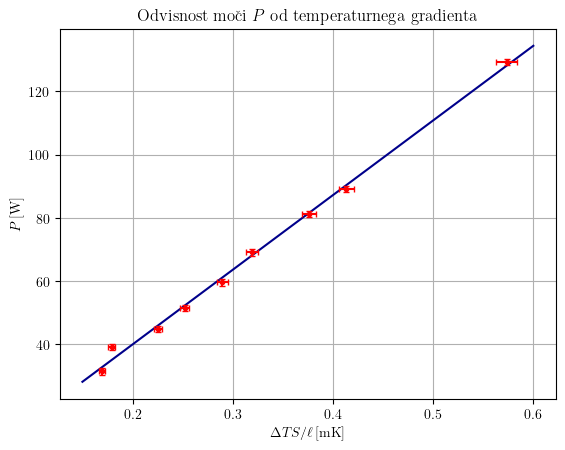

In [15]:
fig, ax = plt.subplots()

ax.errorbar(unp.nominal_values(dT1*S/l), P, xerr=unp.std_devs(dT1*S/l), yerr=[1] + [1]*8, zorder=5, color="r", fmt=".", capsize=2)

x_lin = np.linspace(0.15, 0.6)
ax.plot(x_lin, lin(x_lin, k1, n1), color="darkblue")

ax.set_title(r'Odvisnost moči $P$ od temperaturnega gradienta')
ax.set_xlabel(r'$\Delta T S / \ell \,[\mathrm{mK}]$')
ax.set_ylabel(r"$P\,[\mathrm{W}]$")
ax.grid()
fig.savefig("lambda-fit")